In [40]:
# BEFORE STARTING -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Make sure to have 'lab4_example.pt', 'wiki-interpolate.3gram.arpa', 'model_epoch_10.pt' (under 'checkpoints') and 'optimizer_epoch_10.pt' (under 'checkpoints').

# First time runnning: takes extra long because of the data_loaders (extra 6-7 min)

# Make sure to select mode='test' if you uploaded model_epoch and optimizer_epoch previously, otherwise we must train to get these.

# We are using torch.save and torch.load in order to avoid training.

# TODO: the could could be refractored in many places, this works decently.

# TODO: grid search takes too much time, so I can't really find good values for alpha and beta, even though the code is simple. For now, alpha=0.5, beta=1.0 seems good.

# NB: much of the actual calculation was done using a more advanced GPU (NVIDIA A100, NVIDIA L4) and extended RAM, so I would not try re-create anything without
# a sufficinetly strong GPU. The necessary results should be saved as screenshots in the notebook.

In [2]:
import torch
from torch import nn
import torchaudio
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import numpy as np
import argparse

In [3]:
#!python lab4_main.py  # can take some time to load in my experience, works fine on CPU, maybe faster on CUDA
                      # Make sure all files are in the google.colab files in order for this to work,
                      # requires manually uploading them to colab for every new session I believe.
                      # Sometims it doesn't work, try pasting code into the colab then.

In [4]:
'''
MODEL DEFINITION
'''
class CNNLayerNorm(nn.Module):
	"""Layer normalization built for cnns input"""
	def __init__(self, n_feats):
		super(CNNLayerNorm, self).__init__()
		self.layer_norm = nn.LayerNorm(n_feats)

	def forward(self, x):
		# x (batch, channel, feature, time)
		x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
		x = self.layer_norm(x)
		return x.transpose(2, 3).contiguous() # (batch, channel, feature, time)


class ResidualCNN(nn.Module):
	"""Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
		except with layer norm instead of batch norm
	"""
	def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
		super(ResidualCNN, self).__init__()

		self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
		self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
		self.dropout1 = nn.Dropout(dropout)
		self.dropout2 = nn.Dropout(dropout)
		self.layer_norm1 = CNNLayerNorm(n_feats)
		self.layer_norm2 = CNNLayerNorm(n_feats)

	def forward(self, x):
		residual = x  # (batch, channel, feature, time)
		x = self.layer_norm1(x)
		x = F.gelu(x)
		x = self.dropout1(x)
		x = self.cnn1(x)
		x = self.layer_norm2(x)
		x = F.gelu(x)
		x = self.dropout2(x)
		x = self.cnn2(x)
		x += residual
		return x # (batch, channel, feature, time)

class BidirectionalGRU(nn.Module):

	def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
		super(BidirectionalGRU, self).__init__()

		self.BiGRU = nn.GRU(
			input_size=rnn_dim, hidden_size=hidden_size,
			num_layers=1, batch_first=batch_first, bidirectional=True)
		self.layer_norm = nn.LayerNorm(rnn_dim)
		self.dropout = nn.Dropout(dropout)

	def forward(self, x):
		#print('bi-gru, in:',x.shape)
		x = self.layer_norm(x)
		x = F.gelu(x)
		x, _ = self.BiGRU(x)
		x = self.dropout(x)
		#print('bi-gru, out:',x.shape)
		return x

class SpeechRecognitionModel(nn.Module):
	"""Speech Recognition Model Inspired by DeepSpeech 2"""

	def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
		super(SpeechRecognitionModel, self).__init__()
		n_feats = n_feats//stride
		self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

		# n residual cnn layers with filter size of 32
		self.rescnn_layers = nn.Sequential(*[
			ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
			for _ in range(n_cnn_layers)
		])
		self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
		self.birnn_layers = nn.Sequential(*[
			BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
							 hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
			for i in range(n_rnn_layers)
		])
		self.classifier = nn.Sequential(
			nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
			nn.GELU(),
			nn.Dropout(dropout),
			nn.Linear(rnn_dim, n_class),
			nn.LogSoftmax(dim=2)
		)

	def forward(self, x):
		x = self.cnn(x)
		x = self.rescnn_layers(x)
		sizes = x.size()
		x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
		x = x.transpose(1, 2) # (batch, time, feature)
		x = self.fully_connected(x)
		x = self.birnn_layers(x)
		x = self.classifier(x)
		return x

'''
ACCURACY MEASURES
'''
def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
	if ignore_case == True:
		reference = reference.lower()
		hypothesis = hypothesis.lower()

	ref_words = reference.split(delimiter)
	hyp_words = hypothesis.split(delimiter)
	edit_distance = levenshteinDistance(ref_words, hyp_words)
	ref_len = len(ref_words)

	if ref_len > 0:
		wer = float(edit_distance) / ref_len
	else:
		raise ValueError("empty reference string")
	return wer

def cer(reference, hypothesis, ignore_case=False, remove_space=False):
	if ignore_case == True:
		reference = reference.lower()
		hypothesis = hypothesis.lower()

	join_char = ' '
	if remove_space == True:
		join_char = ''

	reference = join_char.join(filter(None, reference.split(' ')))
	hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

	edit_distance = levenshteinDistance(reference, hypothesis)
	ref_len = len(reference)
	if ref_len > 0:
		cer = float(edit_distance) / ref_len
	else:
		raise ValueError("empty reference string")
	return cer

'''
TRAINING AND TESTING
'''

def train(model, device, train_loader, criterion, optimizer, epoch):
	model.train()
	data_len = len(train_loader.dataset)
	for batch_idx, _data in enumerate(train_loader):
		spectrograms, labels, input_lengths, label_lengths = _data
		spectrograms, labels = spectrograms.to(device), labels.to(device)

		optimizer.zero_grad()
		# model output is (batch, time, n_class)
		output = model(spectrograms)
		# transpose to (time, batch, n_class) in loss function
		loss = criterion(output.transpose(0, 1), labels, input_lengths, label_lengths)
		loss.backward()
		optimizer.step()
		if batch_idx % 100 == 0 or batch_idx == data_len:
			print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
				epoch, batch_idx * len(spectrograms), data_len,
				100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, criterion, epoch):
	print('\nevaluating…')
	model.eval()
	test_loss = 0
	test_cer, test_wer = [], []
	with torch.no_grad():
		for I, _data in enumerate(test_loader):
			spectrograms, labels, input_lengths, label_lengths = _data
			spectrograms, labels = spectrograms.to(device), labels.to(device)

			# model output is (batch, time, n_class)
			output = model(spectrograms)
			# transpose to (time, batch, n_class) in loss function
			loss = criterion(output.transpose(0, 1), labels, input_lengths, label_lengths)
			test_loss += loss.item() / len(test_loader)

			# get target text
			decoded_targets = []
			for i in range(len(labels)):
				decoded_targets.append(intToStr(labels[i][:label_lengths[i]].tolist()))

			# get predicted text
			decoded_preds = greedyDecoder(output)

			# calculate accuracy
			for j in range(len(decoded_preds)):
				test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
				test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

	avg_cer = sum(test_cer)/len(test_cer)
	avg_wer = sum(test_wer)/len(test_wer)
	print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))

# Lab4_proto.py

In [5]:
# DT2119, Lab 4 End-to-end Speech Recognition

# Variables to be defined --------------------------------------
import torch
import torchaudio.transforms as T
import torch.nn as nn
'''
train-time audio transform object, that transforms waveform -> spectrogram, with augmentation
'''
train_audio_transform = nn.Sequential(
    T.MelSpectrogram(sample_rate=16000, n_mels=80),
    T.FrequencyMasking(freq_mask_param=15),
    T.TimeMasking(time_mask_param=35)
)
'''
test-time audio transform object, that transforms waveform -> spectrogram, without augmentation
'''
test_audio_transform = nn.Sequential(
    T.MelSpectrogram(sample_rate=16000, n_mels=80)
)


# Functions to be implemented ----------------------------------

def intToStr(labels):
    '''
        convert list of integers to string
    Args:
        labels: list of ints
    Returns:
        string with space-separated characters
    '''
    if not all(isinstance(label, int) for label in labels):
        raise ValueError("There can only be integers in labels list!")

    return ' '.join(map(str, labels))


def strToInt(text):
    '''
        convert string to list of integers
    Args:
        text: string
    Returns:
        list of ints
    '''
    if not isinstance(text, str):
        raise ValueError("Input must be a string!")

    return [int(part) for part in text.split()]


# Mapping dictionaries
char_to_int = {
    "'": 0, " ": 1, "a": 2, "b": 3, "c": 4, "d": 5, "e": 6, "f": 7, "g": 8,
    "h": 9, "i": 10, "j": 11, "k": 12, "l": 13, "m": 14, "n": 15, "o": 16,
    "p": 17, "q": 18, "r": 19, "s": 20, "t": 21, "u": 22, "v": 23, "w": 24,
    "x": 25, "y": 26, "z": 27
}

int_to_char = {v: k for k, v in char_to_int.items()}


def text_to_int(text):
    """
        convert string to list of integers
    Args:
        text: string
    Returns:
        list of ints
    """
    if not isinstance(text, str):
        raise ValueError("Input must be a string.")

    return [char_to_int[char] for char in text]


def int_to_text(labels):
    """
        convert list of integers to string
    Args:
        labels: list of ints
    Returns:
        string with concatenated characters
    """
    if not all(isinstance(label, int) for label in labels):
        raise ValueError("All elements in the list must be integers.")

    return ''.join(int_to_char[label] for label in labels)


def dataProcessing(data, audio_transform):
    """
    process a batch of speech data
    arguments:
        data: list of tuples, representing one batch. Each tuple is of the form
            (waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id)
        audio_transform: audio transform to apply to the waveform
    returns:
        a tuple of (spectrograms, labels, input_lengths, label_lengths)
        -   spectrograms - tensor of shape B x C x M x T
            where B=batch_size, C=channel, T=time_frames, M=mel_band.
            spectrograms are padded to the longest length in the batch.
        -   labels - tensor of shape B x L where L is label_length.
            labels are padded to the longest length in the batch.
        -   input_lengths - list of half spectrogram lengths before padding
        -   label_lengths - list of label lengths before padding
    """
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []

    for (waveform, sample_rate, utterance, _, _, _) in data:
        spectrogram = audio_transform(waveform)
        spectrogram = spectrogram.squeeze(0).transpose(0, 1)
        spectrograms.append(spectrogram)

        label = text_to_int(utterance.lower())
        labels.append(torch.tensor(label, dtype=torch.int32))

        input_lengths.append(spectrogram.shape[0] // 2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
    spectrograms = spectrograms.unsqueeze(1).transpose(2, 3)

    return spectrograms, labels, input_lengths, label_lengths


def greedyDecoder(output, blank_label=28):
    '''
    Decode a batch of utterances.

    Arguments:
        output: network output tensor, shape B x T x C where B=batch_size, T=time_steps, C=characters
        blank_label: id of the blank label token
        int_to_char: function to convert character IDs to characters

    Returns:
        list of decoded strings
    '''
    batch_size = output.size(0)
    time_steps = output.size(1)
    decoded_output = []

    for i in range(batch_size):
        prev_char = -1
        decoded_sequence = []
        for t in range(time_steps):
            max_prob_char = torch.argmax(output[i, t]).item()
            if max_prob_char != blank_label and (t == 0 or max_prob_char != prev_char):
                decoded_sequence.append(max_prob_char)
            prev_char = max_prob_char

        if int_to_char:
            decoded_sequence = ''.join([int_to_char[c] for c in decoded_sequence])

        decoded_output.append(decoded_sequence)

    return decoded_output

def levenshteinDistance(sequence1, sequence2):
    '''
    Calculate Levenshtein distance (edit distance) between two sequences.

    Arguments:
        sequence1: reference sequence
        sequence2: sequence to compare against the reference

    Returns:
        edit distance (int)
    '''
    len_seq1, len_seq2 = len(sequence1), len(sequence2)
    matrix = [[0] * (len_seq2 + 1) for _ in range(len_seq1 + 1)]

    for i in range(len_seq1 + 1):
        matrix[i][0] = i
    for j in range(len_seq2 + 1):
        matrix[0][j] = j

    for i in range(1, len_seq1 + 1):
        for j in range(1, len_seq2 + 1):
            if sequence1[i - 1] == sequence2[j - 1]:
                matrix[i][j] = matrix[i - 1][j - 1]
            else:
                matrix[i][j] = min(matrix[i - 1][j] + 1,
                                   matrix[i][j - 1] + 1,
                                   matrix[i - 1][j - 1] + 1)

    return matrix[len_seq1][len_seq2]


# 3 **Data**

## 3.1 Representing text

In [6]:
# I don't think he wants testStr and strToInt, despite having them in the proto.
# He probably wants text_to_int(text) and int_to_text(labels), as per the instructions.
testStr = intToStr([3, 2, 6, 5, 4, 3])
print(type(testStr))
testStr

<class 'str'>


'3 2 6 5 4 3'

In [7]:
labels = strToInt(testStr)
print(type(labels))
labels

<class 'list'>


[3, 2, 6, 5, 4, 3]

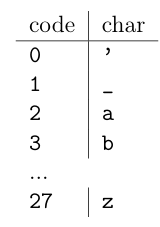

In [8]:
all_char_string = "' abcdefghijklmnopqrstuvwxyz"
int_list = text_to_int(all_char_string)
print(*int_list)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27


In [9]:
#int_list = [i for i in range(0,27+1)]
resulting_char_string = int_to_text(int_list)
print(resulting_char_string)
assert resulting_char_string == all_char_string

' abcdefghijklmnopqrstuvwxyz


## 3.2 Representation and augmentation of the speech signal

In [10]:
example = torch.load('lab4_example.pt')
example.keys()

dict_keys(['data', 'spectrograms', 'labels', 'input_lengths', 'label_lengths'])

In [11]:
print(len(example['data']))
print("First value: \n--------")
example['data'][0]

5
First value: 
--------


(tensor([[0.0003, 0.0003, 0.0004,  ..., 0.0021, 0.0021, 0.0016]]),
 16000,
 'HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE',
 1089,
 134686,
 0)

In [12]:
print(example['spectrograms'].shape)
print("First value: \n--------")
example['spectrograms'][0]

torch.Size([5, 1, 80, 835])
First value: 
--------


tensor([[[2.6046e-03, 1.2348e-03, 1.4951e-03,  ..., 1.5157e-03,
          3.5274e-03, 2.5832e-03],
         [9.4290e-03, 4.4699e-03, 5.4125e-03,  ..., 5.4870e-03,
          1.2769e-02, 9.3513e-03],
         [1.2107e-04, 3.9373e-03, 1.8843e-03,  ..., 4.5020e-03,
          4.6623e-03, 6.7429e-03],
         ...,
         [2.3236e-06, 1.2590e-05, 3.3010e-06,  ..., 9.8374e-06,
          1.7321e-05, 6.5594e-06],
         [1.6269e-06, 1.6525e-05, 8.5944e-06,  ..., 9.9509e-06,
          7.6597e-06, 9.3466e-06],
         [3.0970e-06, 1.5812e-05, 7.8631e-06,  ..., 9.8372e-06,
          1.7456e-05, 1.1849e-05]]])

In [13]:
print(example['labels'].shape)
print("First value: \n--------")
example['labels'][0]

torch.Size([5, 158])
First value: 
--------


tensor([ 9.,  6.,  1.,  9., 16., 17.,  6.,  5.,  1., 21.,  9.,  6., 19.,  6.,
         1., 24., 16., 22., 13.,  5.,  1.,  3.,  6.,  1., 20., 21.,  6., 24.,
         1.,  7., 16., 19.,  1.,  5., 10., 15., 15.,  6., 19.,  1., 21., 22.,
        19., 15., 10., 17., 20.,  1.,  2., 15.,  5.,  1.,  4.,  2., 19., 19.,
        16., 21., 20.,  1.,  2., 15.,  5.,  1.,  3., 19., 22., 10., 20.,  6.,
         5.,  1., 17., 16., 21.,  2., 21., 16.,  6., 20.,  1.,  2., 15.,  5.,
         1.,  7.,  2., 21.,  1., 14., 22., 21., 21., 16., 15.,  1., 17., 10.,
         6.,  4.,  6., 20.,  1., 21., 16.,  1.,  3.,  6.,  1., 13.,  2.,  5.,
        13.,  6.,  5.,  1., 16., 22., 21.,  1., 10., 15.,  1., 21.,  9., 10.,
         4., 12.,  1., 17.,  6., 17., 17.,  6., 19.,  6.,  5.,  1.,  7., 13.,
        16., 22., 19.,  1.,  7.,  2., 21., 21.,  6., 15.,  6.,  5.,  1., 20.,
         2., 22.,  4.,  6.])

In [14]:
example['input_lengths']

[417, 131, 265, 107, 209]

In [15]:
example['label_lengths']

[158, 42, 104, 34, 59]

In [16]:
# Process the example data using train_audio_transform
spectrograms_train, labels_train, input_lengths_train, label_lengths_train = dataProcessing(example['data'], train_audio_transform)

# Process the example data using test_audio_transform
spectrograms_test, labels_test, input_lengths_test, label_lengths_test = dataProcessing(example['data'], test_audio_transform)

# spectrogram tensor, shape: (batch, channels, mel bands, time frames)
# labels tensor, shape: (batch, label length)
# input_lengths int list, Li = Ti / 2
# label_lengths int list, corresponding to length of label strings

print("Training Data:")
print("Spectrograms:", spectrograms_train.shape)
print("Labels:", labels_train.shape)
print("Input Lengths:", input_lengths_train)
print("Label Lengths:", label_lengths_train)

print("\nTesting Data:")
print("Spectrograms:", spectrograms_test.shape)
print("Labels:", labels_test.shape)
print("Input Lengths:", input_lengths_test)
print("Label Lengths:", label_lengths_test)

assert spectrograms_train.shape == spectrograms_test.shape
assert spectrograms_train.shape == example['spectrograms'].shape
assert spectrograms_test.shape == example['spectrograms'].shape
assert input_lengths_train == input_lengths_test
assert label_lengths_train == label_lengths_test
assert input_lengths_train == example['input_lengths']
assert label_lengths_train == example['label_lengths']
assert input_lengths_test == example['input_lengths']
assert label_lengths_test == example['label_lengths']

Training Data:
Spectrograms: torch.Size([5, 1, 80, 835])
Labels: torch.Size([5, 158])
Input Lengths: [417, 131, 265, 107, 209]
Label Lengths: [158, 42, 104, 34, 59]

Testing Data:
Spectrograms: torch.Size([5, 1, 80, 835])
Labels: torch.Size([5, 158])
Input Lengths: [417, 131, 265, 107, 209]
Label Lengths: [158, 42, 104, 34, 59]


In [17]:
# Check that spectrograms_tests are sufficiently close to example['spectrograms']
eps = 1e-06
n = len(example['input_lengths'])
for idx in range(0, n):
  diff_per_elem = torch.sum(torch.abs(spectrograms_test[idx] - example['spectrograms'][idx])) / torch.numel(spectrograms_train[idx])
  #print(diff_per_elem)
  assert diff_per_elem < eps

# 4 The model

The model starts with an **Input: MelSpectrogram**, which represents the speech signal as a time-frequency representation. The **Conv2D Layer** processes these spectrograms to extract initial low-level features from the input. These features are further refined by **Residual CNN Layers**, which include residual connections to help with gradient flow and capture complex patterns in the data. The **Bidirectional GRU Layers** then model temporal dependencies in both forward and backward directions, providing a comprehensive understanding of the context within the speech signal. Additional sequential modeling is performed by **RNN Layers**, which further process the temporal information. The **Fully Connected Layer** then maps the extracted features to a higher-dimensional character space. Finally, the **LogSoftMax Activation** layer converts the outputs to log probabilities for each character, resulting in the **Output: Character Probabilities** used for decoding the speech into text.


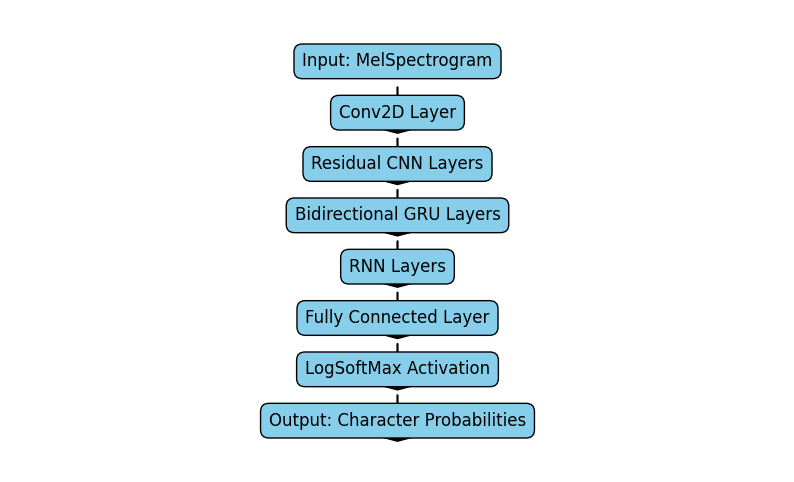

In [18]:
hparams = {
	"n_cnn_layers": 3,
	"n_rnn_layers": 5,
	"rnn_dim": 512,
	"n_class": 29,
	"n_feats": 80,
	"stride": 2,
	"dropout": 0.1,
	"learning_rate": 5e-4,
	"batch_size": 30,
	"epochs": 20
}

In [19]:
hparams

{'n_cnn_layers': 3,
 'n_rnn_layers': 5,
 'rnn_dim': 512,
 'n_class': 29,
 'n_feats': 80,
 'stride': 2,
 'dropout': 0.1,
 'learning_rate': 0.0005,
 'batch_size': 30,
 'epochs': 20}

# 5 Training and testing

In [20]:
learning_rate = hparams['learning_rate']
batch_size = hparams['batch_size']
epochs = hparams['epochs']

In [21]:
# n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
model = SpeechRecognitionModel(*list(hparams.values())[0:6]) # we don't use learning_rate, batch_size and epochs here

In [22]:
spectrograms = spectrograms_train
labels = labels_train
input_lengths = input_lengths_train
label_lengths = label_lengths_train

In [23]:
# Move data to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
spectrograms = spectrograms.to(device)
labels = labels.to(device)

In [24]:
# Forward pass
outputs = model(spectrograms)

In [25]:
# Calculate CTC Loss
ctc_loss_fn = nn.CTCLoss()
log_probs = outputs.permute(1, 0, 2)  # (T, N, C)
loss = ctc_loss_fn(log_probs, labels, input_lengths, label_lengths)
print(f"CTC Loss: {loss.item()}")

CTC Loss: 7.447013854980469


**CTC (Connectionist Temporal Classification) Loss** is a handy loss function for training models where the input and output sequences don't line up perfectly, like in speech recognition. It lets the model predict a sequence of probabilities for each character at each time step, even if people talk at different speeds. CTC uses a special blank token to separate repeated characters, so the model doesn't need to know exactly when each character happens. It works by calculating the negative log probability of the correct sequence over all possible alignments, making it great for tasks like speech and handwriting recognition.


**Levenshtein Distance** is a way to measure how different two strings are by counting the minimum number of single-character edits needed to turn one string into the other. These edits can be insertions, deletions, or substitutions. In the context of speech recognition, we use Levenshtein distance to calculate how close the model's predicted text is to the actual spoken text. This helps us compute metrics like the Word Error Rate (WER) and Character Error Rate (CER), which tell us how well the model is doing at recognizing speech correctly.


In [26]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 18 15:17:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   43C    P0              28W /  72W |   1113MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [27]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils import data
from tqdm import tqdm
import os

# Define hyperparameters
hparams = {
    "n_cnn_layers": 3,
    "n_rnn_layers": 5,
    "rnn_dim": 512,
    "n_class": 29,
    "n_feats": 80,
    "stride": 2,
    "dropout": 0.1,
    "learning_rate": 5e-4,
    "batch_size": 30,
    "epochs": 10
}


def train(model, device, train_loader, criterion, optimizer, epoch, save_dir):
    model.train()
    total_loss = 0
    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}") as pbar:
        for batch_idx, (spectrograms, labels, input_lengths, label_lengths) in enumerate(train_loader):
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(spectrograms)
            log_probs = outputs.permute(1, 0, 2)  # (T, N, C)
            loss = criterion(log_probs, labels, input_lengths, label_lengths)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)
    avg_loss = total_loss / len(train_loader)
    print(f"Training Loss: {avg_loss}")

    # Save the model and optimizer states
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch+1}.pt'))
    torch.save(optimizer.state_dict(), os.path.join(save_dir, f'optimizer_epoch_{epoch+1}.pt'))

def test(model, device, val_loader, criterion, epoch):
    model.eval()
    total_loss = 0
    test_cer, test_wer = [], []
    with tqdm(total=len(val_loader), desc=f"Validation Epoch {epoch+1}") as pbar:
        with torch.no_grad():
            for batch_idx, (spectrograms, labels, input_lengths, label_lengths) in enumerate(val_loader):
                spectrograms, labels = spectrograms.to(device), labels.to(device)
                outputs = model(spectrograms)
                log_probs = outputs.permute(1, 0, 2)  # (T, N, C)
                loss = criterion(log_probs, labels, input_lengths, label_lengths)
                total_loss += loss.item()

                # Decode and compute WER/CER
                decoded_preds = greedyDecoder(outputs, blank_label=28)
                decoded_targets = [int_to_text(labels[i][:label_lengths[i]].tolist()) for i in range(len(labels))]

                for j in range(len(decoded_preds)):
                    #print("target: ", decoded_targets[j])
                    #print("preds: ", decoded_preds[j])
                    test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                    test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

                pbar.set_postfix(loss=loss.item())
                pbar.update(1)
    avg_loss = total_loss / len(val_loader)
    avg_cer = sum(test_cer) / len(test_cer)
    avg_wer = sum(test_wer) / len(test_wer)
    print(f"Validation Loss: {avg_loss}, CER: {avg_cer}, WER: {avg_wer}\n")


def load_model_and_optimizer(model, optimizer, checkpoint_path):
    e = hparams['epochs']
    model.load_state_dict(torch.load(os.path.join(checkpoint_path, f'model_epoch_{e}.pt')))
    optimizer.load_state_dict(torch.load(os.path.join(checkpoint_path, f'optimizer_epoch_{e}.pt')))


use_cuda = torch.cuda.is_available()
torch.manual_seed(7)
device = torch.device("cuda" if use_cuda else "cpu")

# Loading datasets takes roughly 6-7 minutes, only first time
train_dataset = torchaudio.datasets.LIBRISPEECH(".", url='train-clean-100', download=True)
val_dataset = torchaudio.datasets.LIBRISPEECH(".", url='dev-clean', download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH(".", url='test-clean', download=True)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = data.DataLoader(dataset=train_dataset,
        batch_size=hparams['batch_size'],
        shuffle=True,
        collate_fn=lambda x: dataProcessing(x, train_audio_transform),
        **kwargs)

val_loader = data.DataLoader(dataset=val_dataset,
        batch_size=hparams['batch_size'],
        shuffle=True,
        collate_fn=lambda x: dataProcessing(x, test_audio_transform),
        **kwargs)

test_loader = data.DataLoader(dataset=test_dataset,
        batch_size=hparams['batch_size'],
        shuffle=False,
        collate_fn=lambda x: dataProcessing(x, test_audio_transform),
        **kwargs)

model = SpeechRecognitionModel(
  hparams['n_cnn_layers'],
  hparams['n_rnn_layers'],
  hparams['rnn_dim'],
  hparams['n_class'],
  hparams['n_feats'],
  hparams['stride'],
  hparams['dropout']
  ).to(device)

print(model)
print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
criterion = nn.CTCLoss(blank=28).to(device)

# TODO: refractor this, make it easier to understand
# Parameters (replace argparse arguments)
mode = 'test'  # Set mode to 'train', 'test', 'recognize' or ''

if mode == 'train':
  model_path = '' # Empty if 'train'
elif mode == '':
  model_path = '/content/checkpoints/'
else:
  model_path = '/content/checkpoints/'  # Path to the model file to load

wavfiles = []  # List of wav files to recognize
save_dir = 'checkpoints'  # Directory to save model and optimizer states

if model_path != '':
  print("MODEL and OPTIMIZER LOADED!\n")
  load_model_and_optimizer(model, optimizer, model_path)

if mode == 'train':
  for epoch in range(hparams['epochs']):
    train(model, device, train_loader, criterion, optimizer, epoch, save_dir)
    test(model, device, val_loader, criterion, epoch)

elif mode == 'test':
  e = hparams['epochs']
  test(model, device, test_loader, criterion, e)

elif mode == 'recognize':
  for wavfile in wavfiles:
    waveform, sample_rate = torchaudio.load(wavfile, normalize=True)
    spectrogram = test_audio_transform(waveform)
    input = torch.unsqueeze(spectrogram, dim=0).to(device)
    output = model(input)
    text = greedyDecoder(output)
    print('wavfile:', wavfile)
    print('text:', text)


100%|██████████| 5.95G/5.95G [07:54<00:00, 13.5MB/s]
100%|██████████| 322M/322M [00:30<00:00, 11.2MB/s]
100%|██████████| 331M/331M [00:31<00:00, 11.2MB/s]


SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((40,),

Validation Epoch 11:   0%|          | 0/88 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation Epoch 11: 100%|██████████| 88/88 [01:42<00:00,  1.17s/it, loss=0.505]

Validation Loss: 0.580578404394063, CER: 0.17260947207517785, WER: 0.500932108323908



Result for seven epochs, then GPU disconnected.

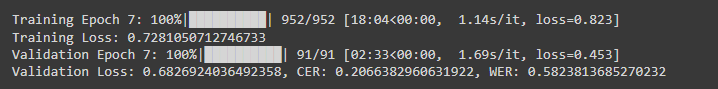

Validation loss, CER, WER after 10 epochs, using Nvidia A100

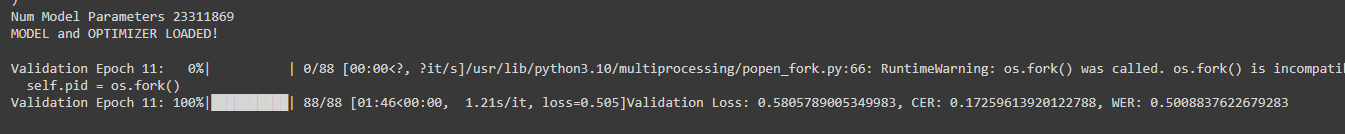

In [29]:
spectrograms = spectrograms_train
labels = labels_train
'''
spectrograms, labels = spectrograms.to(device), labels.to(device)
outputs = model(spectrograms)
decoded_preds = greedyDecoder(outputs, blank_label=28)
decoded_targets = [int_to_text(labels[i][:label_lengths[i]].tolist()) for i in range(len(labels))]
print("Target first, greedy decoder second")
print(*decoded_targets)
print(*decoded_preds)
'''

'\nspectrograms, labels = spectrograms.to(device), labels.to(device)\noutputs = model(spectrograms)\ndecoded_preds = greedyDecoder(outputs, blank_label=28)\ndecoded_targets = [int_to_text(labels[i][:label_lengths[i]].tolist()) for i in range(len(labels))]\nprint("Target first, greedy decoder second")\nprint(*decoded_targets)\nprint(*decoded_preds)\n'

In [30]:
#TODO: does everything need to be here? It started working only when I did all of this for some reason
!pip uninstall -y kenlm
!pip uninstall -y pyctcdecode
!apt-get update
!apt-get install -y build-essential cmake
!git clone https://github.com/kpu/kenlm.git
!cd kenlm && mkdir build && cd build && cmake .. && make -j2
!pip install https://github.com/kpu/kenlm/archive/master.zip
!pip install pyctcdecode

import site

# List all site directories
site_dirs = site.getsitepackages()
print("Python searches for packages in the following directories:")
for dir in site_dirs:
    print(dir)

# Check where 'pyctcdecode' is installed
try:
    import pyctcdecode
    print(f"\n'pyctcdecode' is installed at: {pyctcdecode.__file__}")
except ImportError:
    print("\n'pyctcdecode' is not installed.")

# Check where 'kenlm' is installed
try:
    import kenlm
    print(f"\n'kenlm' is installed at: {kenlm.__file__}")
except ImportError:
    print("\n'kenlm' is not installed.")


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,118 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 2,351 kB in 4s (570 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information

# 5.5 Language model

In [31]:
from pyctcdecode import build_ctcdecoder
import kenlm

In [32]:
labels_LMD = list(char_to_int.keys())
#labels_LMD.append('28')  # Add blank '28'-token for CTC loss
print(*labels_LMD)

'   a b c d e f g h i j k l m n o p q r s t u v w x y z


An **n-gram language model** is a tool that helps predict the next word in a sequence based on the last 'n-1' words. It's like having a predictive text that looks at a few words back to guess the next one. For example, in a bigram model (n=2), it looks at the previous word; in a trigram model (n=3), it looks at the last two words. We use n-gram models in speech recognition to make the predicted text more accurate and natural-sounding by ensuring that the sequences of words it produces make sense in the context of the language. In our case, we are using a 3-gram model trained on 2 million words from Wikipedia.


In [33]:
import torch
from pyctcdecode import build_ctcdecoder

def languageModelDecoder(outputs, labels, model_path, alpha=0.5, beta=1.0):
    """
    Decode the output using a pre-trained N-gram language model.

    Parameters:
    outputs (torch.Tensor): The model output.
    labels (list): List of characters.
    model_path (str): Path to the pre-trained language model.
    alpha (float): Weight for the language model.
    beta (float): Weight for the word insertion.

    Returns:
    list: Decoded texts.
    """
    # Build the CTC decoder
    decoder = build_ctcdecoder(
        labels=labels,
        kenlm_model_path=model_path,
        alpha=alpha,
        beta=beta
    )

    # Decode the output batch
    output_np = outputs.cpu().detach().numpy()
    decoded_texts = decoder.decode_batch(None,output_np)

    return decoded_texts

# Example usage
# Assuming 'spectrograms_train', 'labels_train', 'model', and 'device' are defined elsewhere in your code

spectrograms = spectrograms_train
labels = labels_train
spectrograms, labels = spectrograms.to(device), labels.to(device)
outputs = model(spectrograms)

# Path to the uploaded language model file
wiki_path = '/content/wiki-interpolate.3gram.arpa'

# Decode using the language model decoder
decoded_preds_LMD = languageModelDecoder(outputs, labels_LMD, wiki_path)
decode_preds_GD = greedyDecoder(outputs, blank_label=28)
decoded_targets = [int_to_text(labels[i][:label_lengths[i]].tolist()) for i in range(len(labels))]
print("1) Target, 2) Language model decoder, 3) Greedy decoder (no language model)")
print(*decoded_targets)
print(*decoded_preds_LMD)
print(*decode_preds_GD)

1) Target, 2) Language model decoder, 3) Greedy decoder (no language model)
he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce stuff it into you his belly counselled him after early nightfall the yellow lamps would light up here and there the squalid quarter of the brothels hello bertie any good in your mind number ten fresh nelly is waiting on you good night husband
he hoped there would be stoo for dinner terms and characts and brosed potatoes and that mutant pieces to be ladledout in the thick pepered flower fatensos stuff ed into you his belly count him after early nightfall the inlets would light ap here and there the squalled quarter of the brofols overt and he god in a might non burden fresh newly as waiting on you could at husband
he hoped there would tbe sto hore diner tersond charatsand brosed peta os and that muten't peces to be ladled out an he thick peppered flower fa

Run your model with and without language model and compare the results, both subjectively, and by calculating the CER and WER over the test set. What observations can you make?
  - Without the language model - i.e., just using the greedy decomposer - our model appears to perform decently, although it makes up words that clearly don't exist (see example above). With the language model however, the spelling improves noticeably.
  - We can compare average loss, CER and WER for both decomposers. We notice that while the loss and CER are almost identical, the WER improves dramatically. This makes sense, since the problem earlier mainly had to do with spelling, so using a language model mainly improves the WER. Moreover, the language model takes more time to run because of the greater complexity associated with searching on an n-gram model.

In [34]:
def test(model, device, val_loader, criterion, epoch):
    model.eval()
    total_loss = 0
    test_cer, test_wer = [], []
    with tqdm(total=len(val_loader), desc=f"Validation Epoch {epoch+1}") as pbar:
        with torch.no_grad():
            for batch_idx, (spectrograms, labels, input_lengths, label_lengths) in enumerate(val_loader):
                spectrograms, labels = spectrograms.to(device), labels.to(device)
                outputs = model(spectrograms)
                log_probs = outputs.permute(1, 0, 2)  # (T, N, C)
                loss = criterion(log_probs, labels, input_lengths, label_lengths)
                total_loss += loss.item()

                # Decode and compute WER/CER w. Lan
                #decoded_preds = greedyDecoder(outputs, blank_label=28)
                decoded_preds = languageModelDecoder(outputs, labels_LMD, wiki_path)
                decoded_targets = [int_to_text(labels[i][:label_lengths[i]].tolist()) for i in range(len(labels))]

                for j in range(len(decoded_preds)):
                    test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                    test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

                pbar.set_postfix(loss=loss.item())
                pbar.update(1)
    avg_loss = total_loss / len(val_loader)
    avg_cer = sum(test_cer) / len(test_cer)
    avg_wer = sum(test_wer) / len(test_wer)
    print(f"Validation Loss: {avg_loss}, CER: {avg_cer}, WER: {avg_wer}\n")

In [35]:
test_loader = data.DataLoader(dataset=test_dataset,
        batch_size=hparams['batch_size'],
        shuffle=False,
        collate_fn=lambda x: dataProcessing(x, test_audio_transform),
        **kwargs)

test(model, device, test_loader, criterion, hparams['epochs'])

Validation Epoch 11: 100%|██████████| 88/88 [10:02<00:00,  6.84s/it, loss=0.505]

Validation Loss: 0.580578404394063, CER: 0.14504668885429675, WER: 0.34851080353714725



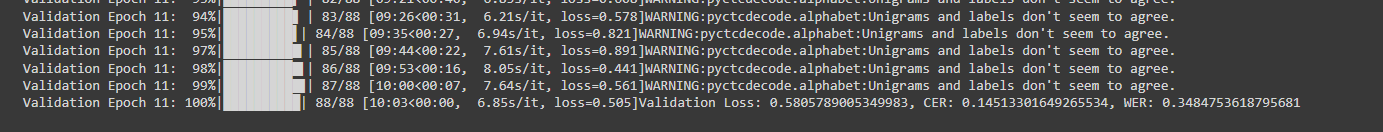

In [36]:
def grid_search_alpha_beta(model, device, val_loader, criterion, labels_LMD, model_path, alpha_values, beta_values, int_to_text, epoch=0):
    """
    Perform grid search to find the best alpha and beta values.

    Parameters:
    model (nn.Module): The speech recognition model.
    device (torch.device): The device to run the model on.
    val_loader (DataLoader): DataLoader for the validation set.
    criterion (nn.Module): The loss criterion.
    labels_LMD (list): List of characters.
    model_path (str): Path to the pre-trained language model.
    alpha_values (list): List of alpha values to try.
    beta_values (list): List of beta values to try.
    int_to_text (function): Function to convert integer labels to text.
    epoch (int): The current epoch number.

    Returns:
    tuple: Best alpha, best beta, and corresponding WER.
    """
    best_wer = float('inf')
    best_alpha = None
    best_beta = None

    for alpha in alpha_values:
        for beta in beta_values:
            total_loss = 0
            test_cer, test_wer = [], []
            model.eval()
            with tqdm(total=len(val_loader), desc=f"Validation Epoch {epoch+1} - Alpha: {alpha:.2f}, Beta: {beta:.2f}") as pbar:
                with torch.no_grad():
                    for batch_idx, (spectrograms, labels, input_lengths, label_lengths) in enumerate(val_loader):
                        spectrograms, labels = spectrograms.to(device), labels.to(device)
                        outputs = model(spectrograms)
                        log_probs = outputs.permute(1, 0, 2)  # (T, N, C)
                        loss = criterion(log_probs, labels, input_lengths, label_lengths)
                        total_loss += loss.item()

                        decoded_preds = languageModelDecoder(outputs, labels_LMD, model_path, alpha=alpha, beta=beta)
                        decoded_targets = [int_to_text(labels[i][:label_lengths[i]].tolist()) for i in range(len(labels))]

                        for j in range(len(decoded_preds)):
                            test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                            test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

                        pbar.set_postfix(loss=loss.item())
                        pbar.update(1)
            avg_wer = sum(test_wer) / len(test_wer)
            if avg_wer < best_wer:
                best_wer = avg_wer
                best_alpha = alpha
                best_beta = beta

    print(f"Best alpha: {best_alpha}, Best beta: {best_beta}, Best WER: {best_wer}")
    return best_alpha, best_beta, best_wer

alpha_values = np.linspace(0, 1, 5)
beta_values = np.linspace(0, 1, 5)
print(alpha_values)

wiki_path = '/content/wiki-interpolate.3gram.arpa'

[0.   0.25 0.5  0.75 1.  ]


In [37]:
# Perform the grid search on the validation set, it works, but it takes A LOT OF TIME
# best_alpha, best_beta, best_wer = grid_search_alpha_beta(model, device, val_loader, criterion, labels_LMD, wiki_path, alpha_values, beta_values, int_to_text, epoch=0)

In [38]:
#a good option seems to be:
#alpha = 0.5, beta=1.0, WER=0.348...

# 5.6 Summing up

How do you think the accuracy of the model could be improved further?

Setting aside the model for now, we could improve the training procedure in various ways.
  - Use a learning rate schedular (cyclical, annealing, cosine, etc)
  - More advanced optimizer, e.g. AdamW (has weight decay).
  - Use gradient clipping to avoid exploding gradients when using RNNs or LSTMs.
  - Include data augmentation for sake of regularization.
  - Include dropout for sake of regularization.

Can you propose any changes to he model?
  - The simplest model upgrade would be adding more model depth and width; that is, more CNN and RNN layers. This would help the network capture more complex features (using CNN layers) and better capture temporal dependencies (using RNN layers).
  - More advanced variants of RNN, such as LSTM (Long Short-Term Memory), could capture longer dependencies, which is helpful in sequence modelling.
  - Batch normnalization could help in reducing vanishing gradients.
  - More residual (skip) connections, especially for deep networks.
